In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Load the dataset
url = 'https://drive.google.com/uc?id=1FHmYNLs9v0Enc-UExEMpitOFGsWvB2dP'
df = pd.read_csv(url)

# Display basic info
print(df.info())
print(df.head())

# Check for missing values
print(df.isnull().sum())

# Separate features and target
X = df.drop('price', axis=1)
y = df['price']

# Identify numerical and categorical columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

# Preprocessing pipeline
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null    int64  
 1

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Support Vector': SVR()
}

# Train and evaluate models
results = {}
for name, model in models.items():
    # Create pipeline
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                          ('model', model)])
    
    # Train model
    pipe.fit(X_train, y_train)
    
    # Predict
    y_pred = pipe.predict(X_test)
    
    # Evaluate
    results[name] = {
        'R2': r2_score(y_test, y_pred),
        'MSE': mean_squared_error(y_test, y_pred),
        'MAE': mean_absolute_error(y_test, y_pred)
    }

# Convert results to DataFrame
results_df = pd.DataFrame(results).T
print(results_df)

                         R2           MSE          MAE
Linear Regression -1.261189  1.785074e+08  7036.822282
Decision Tree      0.855262  1.142623e+07  2109.479683
Random Forest      0.953560  3.666127e+06  1376.486902
Gradient Boosting  0.933493  5.250340e+06  1650.743628
Support Vector    -0.099864  8.682769e+07  5695.713406


In [5]:
# Display results
print(results_df.sort_values('R2', ascending=False))

# Best model based on R2 score
best_model_name = results_df['R2'].idxmax()
best_model = models[best_model_name]
print(f"\nBest performing model: {best_model_name}")

                         R2           MSE          MAE
Random Forest      0.953560  3.666127e+06  1376.486902
Gradient Boosting  0.933493  5.250340e+06  1650.743628
Decision Tree      0.855262  1.142623e+07  2109.479683
Support Vector    -0.099864  8.682769e+07  5695.713406
Linear Regression -1.261189  1.785074e+08  7036.822282

Best performing model: Random Forest


       Feature  Importance
7   enginesize    0.551713
6   curbweight    0.287955
14  highwaympg    0.042525
11  horsepower    0.031478
0       car_ID    0.019818
4     carwidth    0.011473
2    wheelbase    0.005723
3    carlength    0.005706
13     citympg    0.004283
12     peakrpm    0.004047


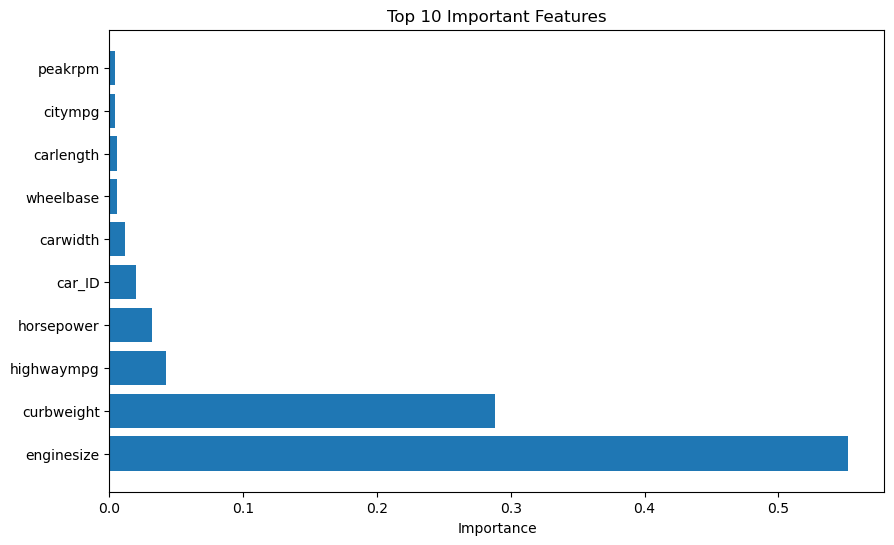

In [7]:
# Get feature names after one-hot encoding
preprocessor.fit(X_train)
feature_names = (numerical_cols.tolist() + 
                 list(preprocessor.named_transformers_['cat']
                      .named_steps['onehot']
                      .get_feature_names_out(categorical_cols)))

# Get feature importances
best_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', best_model)])
best_pipe.fit(X_train, y_train)

if hasattr(best_model, 'feature_importances_'):
    importances = best_pipe.named_steps['model'].feature_importances_
    feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feature_importance = feature_importance.sort_values('Importance', ascending=False)
    print(feature_importance.head(10))
    
    # Plot top features
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['Feature'][:10], feature_importance['Importance'][:10])
    plt.xlabel('Importance')
    plt.title('Top 10 Important Features')
    plt.show()